<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Sebastian Raschka가 집필한 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> 도서를 위한 보조 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 5장: 라벨 없는 데이터로 사전 학습

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # OpenAI 사전 학습 가중치용
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.6.0
tensorflow version: 2.18.0


- 이 장에서는 LLM 사전 학습을 위해 학습 루프와 기본 모델 평가 코드를 구현합니다.
- 장의 마지막에는 OpenAI가 공개한 사전 학습 가중치를 모델에 불러옵니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp" width=500px>

- 이 장에서 다루는 주제는 아래와 같습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## 5.1 생성형 텍스트 모델 평가

- 이 절은 이전 장의 코드를 사용해 GPT 모델을 초기화하는 과정을 간단히 복습하면서 시작합니다.
- 이어서 LLM의 기본 평가 지표를 살펴봅니다.
- 마지막으로 이러한 평가 지표를 학습 및 검증 데이터셋에 적용합니다.

### 5.1.1 GPT로 텍스트 생성하기

- 이전 장의 코드를 사용해 GPT 모델을 초기화합니다.

In [2]:
import torch
from previous_chapters import GPTModel
# 로컬에 `previous_chapters.py` 파일이 없다면
# `llms-from-scratch` PyPI 패키지에서 가져올 수 있습니다.
# 자세한 내용: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 예)
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 어휘 수
    "context_length": 256, # (기존 1024에서) 줄인 컨텍스트 길이
    "emb_dim": 768,        # 임베딩 차원
    "n_heads": 12,         # 어텐션 헤드 수
    "n_layers": 12,        # 층 수
    "drop_rate": 0.1,      # 드롭아웃 비율
    "qkv_bias": False      # 쿼리-키-값 편향
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- 위에서는 드롭아웃을 0.1로 사용했지만, 요즘에는 드롭아웃 없이 LLM을 학습하는 경우도 흔합니다.
- 최신 LLM은 `nn.Linear` 층의 쿼리, 키, 값 행렬에 편향 벡터를 사용하지 않으며(초기 GPT 모델과 달리) 이는 `"qkv_bias": False` 설정으로 반영됩니다.
- 모델 학습에 필요한 연산 자원을 줄이기 위해 컨텍스트 길이(`context_length`)를 256 토큰으로 줄였지만, 원래 1억 2,400만 파라미터 GPT-2 모델은 1024 토큰을 사용했습니다.
  - 더 많은 독자가 노트북에서도 예제 코드를 따라 실행할 수 있도록 하기 위한 선택입니다.
  - 물론 `context_length`를 1024 토큰으로 늘려도 되며, 별도의 코드 변경이 필요하지 않습니다.
  - 이후에는 사전 학습된 가중치에서 `context_length` 1024를 사용하는 모델을 불러올 예정입니다.

- 다음으로 이전 장의 `generate_text_simple` 함수를 사용해 텍스트를 생성합니다.
- 또한 이 장 전반에서 사용할 토큰과 텍스트 간 변환을 위해 `text_to_token_ids`와 `token_ids_to_text` 편의 함수를 정의합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=500px>

In [3]:
import tiktoken
from previous_chapters import generate_text_simple

# 다른 방법:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 배치 차원 추가
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 배치 차원 제거
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 위에서 보듯이 모델은 아직 학습되지 않았기 때문에 좋은 텍스트를 생성하지 못합니다.
- 그렇다면 학습 중에 "좋은 텍스트"를 수치로 측정하고 추적하려면 어떻게 해야 할까요?
- 다음 절에서는 생성된 출력의 손실 값을 계산하는 지표를 소개하여 학습 진행 상황을 측정합니다.
- 이후 LLM 미세 조정 장에서는 모델 품질을 평가하는 다른 방법도 다룹니다.

<br>

### 5.1.2 텍스트 생성 손실 계산: 크로스 엔트로피와 퍼플렉서티

- `inputs` 텐서에 2개의 학습 예시(행)에 대한 토큰 ID가 들어 있다고 가정해봅시다.
- `inputs`에 대응하는 `targets`에는 모델이 생성하길 원하는 토큰 ID가 담겨 있습니다.
- 2장에서 데이터 로더를 구현하며 설명했듯이 `targets`는 `inputs`를 한 칸 이동한 형태입니다.

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- `inputs`를 모델에 넣으면 3개의 토큰으로 구성된 2개 입력 예시에 대한 로짓 벡터를 얻습니다.
- 각 토큰은 어휘 크기에 해당하는 50,257차원 벡터입니다.
- 소프트맥스 함수를 적용하면 로짓 텐서를 같은 차원의 확률 점수 텐서로 바꿀 수 있습니다.

In [5]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # 어휘에 있는 각 토큰의 확률
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 아래 그림은 설명을 위해 매우 작은 어휘를 사용해 확률 점수를 다시 텍스트로 변환하는 과정을 간략히 보여줍니다. 이는 이전 장 끝부분에서 다뤘던 내용입니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- 앞선 장에서 살펴본 것처럼 `argmax` 함수를 적용해 확률 점수를 예측 토큰 ID로 바꿀 수 있습니다.
- 위의 소프트맥스 함수는 각 토큰마다 50,257차원 벡터를 만들어 주며, `argmax` 함수는 이 벡터에서 확률이 가장 높은 위치, 즉 해당 토큰의 예측 토큰 ID를 반환합니다.

- 입력 배치가 3개 토큰으로 구성된 2개이므로 2x3개의 예측 토큰 ID를 얻습니다.

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 이 토큰들을 디코딩해보면 타깃 토큰과 상당히 다르다는 것을 알 수 있습니다.

In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 아직 모델이 학습되지 않았기 때문입니다.
- 모델을 학습시키려면 정답(타깃)과 얼마나 차이가 나는지 알아야 합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- 타깃 인덱스에 해당하는 토큰 확률은 다음과 같습니다.

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 이 값들을 모두 최대화하여 확률 1에 가깝게 만들고 싶습니다.
- 수학적 최적화에서는 확률 점수 자체보다 로그 확률을 최대화하는 것이 더 다루기 쉬운데, 자세한 내용은 [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM) 강의에서 확인할 수 있습니다.

In [9]:
# 모든 토큰 확률의 로그를 계산
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 다음으로 로그 확률의 평균을 계산합니다.

In [10]:
# 각 토큰에 대한 평균 확률을 계산
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 모델 가중치를 최적화해 이 평균 로그 확률을 가능한 크게 만드는 것이 목표입니다.
- 로그 특성상 최대값은 0이며, 현재 값은 0과 거리가 있습니다.

- 딥러닝에서는 평균 로그 확률을 최대화하는 대신 음수 평균 로그 확률을 최소화하는 것이 일반적입니다. 우리 예시에서는 -10.7722를 0에 가깝게 만들기 위해 최대화하는 대신 10.7722를 0에 가깝게 만들도록 최소화합니다.
- -10.7722의 부호를 바꾼 10.7722는 딥러닝에서 크로스 엔트로피 손실이라고 부릅니다.

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- 위 과정을 수행하는 `cross_entropy` 함수가 이미 PyTorch에 구현되어 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=400px>

- `cross_entropy` 함수를 적용하기 전에 로짓과 타깃의 형태를 확인해 봅시다.

In [12]:
# 로짓의 형태: (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# 타깃의 형태: (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- PyTorch의 `cross_entropy` 함수에 넣기 위해 배치 차원을 합쳐 텐서를 평탄화합니다.

In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 타깃은 토큰 ID이며 이는 로짓 텐서에서 최대화하고 싶은 인덱스 위치를 뜻합니다.
- PyTorch의 `cross_entropy` 함수는 해당 토큰 인덱스에 대해 소프트맥스와 로그 확률 계산을 내부적으로 처리합니다.

In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 크로스 엔트로피 손실과 관련된 개념으로 LLM의 퍼플렉서티가 있습니다.
- 퍼플렉서티는 크로스 엔트로피 손실에 지수를 취한 값입니다.

In [15]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 퍼플렉서티는 각 단계에서 모델이 확신하지 못하는 유효 어휘 크기로 이해할 수 있어 더 직관적이라고 여겨집니다(위 예에서는 48,725개의 단어 또는 토큰).
- 다시 말해 퍼플렉서티는 모델이 예측한 확률 분포가 데이터셋의 실제 단어 분포와 얼마나 잘 맞는지를 나타냅니다.
- 손실과 마찬가지로 퍼플렉서티가 낮을수록 모델 예측이 실제 분포에 더 가깝습니다.

### 5.1.3 학습 및 검증 세트 손실 계산

- 이번 LLM 학습에는 비교적 작은 데이터셋(사실상 짧은 단편 소설 한 편)만 사용합니다.
- 그 이유는 다음과 같습니다.
  - 전용 GPU가 없어도 노트북에서 몇 분 안에 예제를 실행할 수 있습니다.
  - 학습이 비교적 빠르게 끝나 교육용으로 적합합니다(몇 분 vs. 몇 주).
  - 퍼블릭 도메인 텍스트를 사용하므로 이용 권한을 침해하지 않고 저장소 용량도 크게 늘리지 않습니다.


- 예를 들어 Llama 2 7B 모델은 2조 토큰 학습에 A100 GPU 184,320 GPU-시간이 필요했습니다.
  - 이 글을 쓰는 시점 기준으로 AWS의 8xA100 클라우드 서버 비용은 시간당 약 $30입니다.
  - 대략 계산하면 184,320 / 8 * $30 = 약 $690,000가 듭니다.

- 아래에서는 2장에서 사용했던 데이터셋과 동일한 것을 사용합니다.

In [16]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 텍스트가 제대로 로드됐는지 처음과 마지막 99자를 출력해 빠르게 확인합니다.

In [17]:
# 처음 99자
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [18]:
# 마지막 99자
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 토큰 수가 5,145개라 LLM 학습에는 매우 짧지만, 이번에는 교육 목적이며 이후 사전 학습 가중치를 불러올 예정입니다.

- 다음으로 데이터셋을 학습과 검증 세트로 나누고, 2장에서 만든 데이터 로더를 사용해 LLM 학습 배치를 준비합니다.
- 시각화를 위해 아래 그림은 `max_length=6`으로 가정하지만, 학습 로더에서는 LLM이 지원하는 컨텍스트 길이와 동일하게 설정합니다.
- 아래 그림에는 단순화를 위해 입력 토큰만 표시했습니다.
    - 텍스트의 다음 단어를 예측하도록 학습하므로 타깃은 입력과 같지만 한 칸 오른쪽으로 이동합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [20]:
from previous_chapters import create_dataloader_v1
# 다른 방법:
# from llms_from_scratch.ch02 import create_dataloader_v1

# 학습/검증 비율
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [21]:
# 점검용 확인

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 연산 자원 수요를 줄이고 데이터셋이 워낙 작기 때문에 비교적 작은 배치 크기를 사용합니다.
- 예를 들어 Llama 2 7B는 배치 크기 1024로 학습했습니다.

- 데이터가 올바르게 로드됐는지 확인하고 싶다면 다음을 참고하세요.

In [22]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 토큰 길이가 예상 범위인지 확인하는 또 다른 선택적 검사입니다.

In [23]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 다음으로 주어진 배치의 크로스 엔트로피 손실을 계산하는 유틸리티 함수를 구현합니다.
- 또한 데이터 로더에서 지정한 배치 수만큼 손실을 계산하는 두 번째 유틸리티 함수를 구현합니다.

In [24]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 데이터 로더의 전체 배치 수에 맞추도록 배치 수를 줄입니다.
        # 지정한 num_batches가 데이터 로더 배치 수보다 큰 경우
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- CUDA 지원 GPU가 있는 경우 별도 코드 변경 없이 LLM이 GPU에서 학습됩니다.
- `device` 설정을 통해 데이터가 LLM 모델과 같은 장치로 로드되도록 합니다.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 참고:
# 아래 줄의 주석을 해제하면(가능한 경우) Apple Silicon 칩에서 코드를 실행할 수 있습니다.
# M3 MacBook Air 기준으로 Apple CPU보다 약 2배 빠릅니다.
# 다만 손실 값은 약간 다를 수 있습니다.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # nn.Module 클래스는 model = model.to(device) 할당이 필요 없음


torch.manual_seed(123) # 데이터 로더 셔플에 따른 재현성을 위해 설정

with torch.no_grad(): # 아직 학습하지 않으므로 효율을 위해 그래디언트 추적 비활성화
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 LLM 학습하기

- 이제 이 절에서는 드디어 LLM을 학습시키는 코드를 구현합니다.
- 단순한 학습 함수에 집중합니다. 학습률 워밍업, 코사인 감쇠, 그래디언트 클리핑 등 고급 기법을 추가하고 싶다면 [부록 D](../../appendix-D/01_main-chapter-code)를 참고하세요.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width="300px">

In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 손실과 처리한 토큰 수를 저장할 리스트 초기화
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 메인 학습 루프
    for epoch in range(num_epochs):
        model.train()  # 학습 모드로 전환
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 이전 배치의 그래디언트 초기화
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 손실 그래디언트 계산
            optimizer.step() # 손실 그래디언트로 가중치 업데이트
            tokens_seen += input_batch.numel()
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 각 에폭이 끝난 뒤 샘플 텍스트 출력
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 위에서 정의한 학습 함수를 사용해 LLM을 학습해 보겠습니다.

In [27]:
# 참고:
# 실행 시간을 계산하려면 아래 코드를 주석 해제하세요
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# 참고:
# 실행 시간을 출력하려면 아래 코드를 주석 해제하세요
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

- 컴퓨터마다 손실 값이 조금 다를 수 있지만 대략 비슷하다면(학습 손실 < 1, 검증 손실 < 7) 걱정하지 않아도 됩니다.
- 이러한 작은 차이는 GPU 하드웨어나 CUDA 버전, 최신 PyTorch 버전의 사소한 변경 때문에 발생할 수 있습니다.
- CPU에서 실행하더라도 약간 다른 값을 볼 수 있습니다. PyTorch 컴파일 방식에 따라 운영체제마다 `nn.Dropout`이 다르게 동작하는 점이 원인일 수 있으며, 이에 대해서는 [PyTorch 이슈 트래커](https://github.com/pytorch/pytorch/issues/121595)에 설명되어 있습니다.

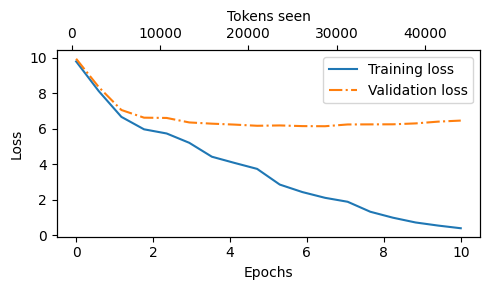

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 에폭별 학습/검증 손실 그래프 그리기
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # x축 눈금을 정수로만 표시

    # 처리한 토큰 수를 위한 두 번째 x축 생성
    ax2 = ax1.twiny()  # 동일한 y축을 공유하는 두 번째 x축 생성
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 눈금 정렬용 보이지 않는 플롯
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # 여유 공간을 확보하도록 레이아웃 조정
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 위 결과에서 모델이 처음에는 의미 없는 단어 나열을 생성하다가 나중에는 문법적으로 그럴듯한 문장을 생성하기 시작함을 볼 수 있습니다.
- 그러나 학습 및 검증 손실을 보면 모델이 과적합하기 시작합니다.
- 마지막 부분에서 생성한 문장을 살펴보면 학습 데이터와 완전히 동일한 구절이 포함되어 있을 것입니다. 즉, 데이터를 그대로 암기합니다.
- 이후에는 이러한 암기를 어느 정도 완화할 수 있는 디코딩 전략을 다룹니다.
- 여기서 과적합이 발생하는 이유는 학습 세트가 매우 작고 반복 학습을 여러 번 수행했기 때문입니다.
  - 이번 LLM 학습은 주로 교육 목적이며, 모델이 일관된 문장을 생성할 수 있는지만 확인하면 됩니다.
  - 수 주 또는 수개월 동안 값비싼 하드웨어로 학습하는 대신, 이후에는 사전 학습된 가중치를 불러옵니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

**학습률 워밍업, 코사인 감쇠, 그래디언트 클리핑 등 고급 기법을 추가하고 싶다면 [부록 D](../../appendix-D/01_main-chapter-code)를 참고하세요.**

**더 큰 학습 데이터셋과 더 긴 학습을 보고 싶다면 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)을 참고하세요.**

## 5.3 무작위성을 제어하는 디코딩 전략

- 앞에서 학습한 GPT 모델처럼 비교적 작은 LLM에서 추론은 비용이 크지 않으므로, 학습을 GPU에서 수행했더라도 추론에는 GPU가 필요하지 않습니다.
- 이전 장에서 작성하고 간단한 학습 함수 안에서도 사용했던 `generate_text_simple` 함수를 이용해 한 번에 한 단어(토큰)씩 새로운 텍스트를 생성할 수 있습니다.
- 5.1.2절에서 설명했듯이 다음에 생성되는 토큰은 어휘 전체에서 확률이 가장 큰 토큰입니다.

In [29]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


- 위의 `generate_text_simple` 함수를 여러 번 실행해도 LLM은 항상 같은 출력을 생성합니다.
- 이제 `generate_text_simple`을 변형하기 위한 두 가지 디코딩 전략, 즉 *temperature scaling*과 *top-k* 샘플링을 소개합니다.
- 이를 통해 생성 텍스트의 무작위성과 다양성을 조절할 수 있습니다.

### 5.3.1 온도 조절(temperature scaling)

- 지금까지는 항상 `torch.argmax`를 사용해 확률이 가장 높은 토큰을 다음 토큰으로 선택했습니다.
- 다양성을 추가하려면 확률 분포에서 샘플링하는 `torch.multinomial(probs, num_samples=1)`을 사용해 다음 토큰을 뽑을 수 있습니다.
- 이때 각 인덱스가 선택될 확률은 입력 텐서에 있는 해당 확률과 같습니다.

- 매우 작은 어휘를 가정해 다음 토큰을 생성하는 과정을 간단히 복습해 봅시다.

In [30]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# 입력이 "every effort moves you"라고 가정하면 LLM이
# 다음 토큰에 대해 아래와 같은 로짓을 반환합니다.
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 다음에 생성되는 토큰은 다음과 같습니다.
print(inverse_vocab[next_token_id])

forward


In [31]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- 가장 가능성이 높은 토큰을 `torch.argmax`로 고르는 대신, 소프트맥스 분포에서 샘플링하기 위해 `torch.multinomial(probas, num_samples=1)`을 사용합니다.
- 이해를 돕기 위해 원래 소프트맥스 확률로 다음 토큰을 1,000번 샘플링하면 어떻게 되는지 살펴보겠습니다.

In [32]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # 재현성을 위한 시드 고정
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 온도 조절(temperature scaling)이라는 개념을 이용해 분포와 선택 과정을 제어할 수 있습니다.
- 여기서 "온도 조절"은 단순히 로짓을 0보다 큰 수로 나누는 작업입니다.
- 온도가 1보다 크면 소프트맥스 이후의 토큰 확률이 더 균등하게 분포합니다.
- 온도가 1보다 작으면 분포가 더 뾰족해져 가장 가능성이 높은 토큰이 더 자주 선택됩니다.

- 운영체제에 따라 드롭아웃 결과가 다르게 보일 수 있습니다. 관련 내용은 [PyTorch 이슈 트래커](https://github.com/pytorch/pytorch/issues/121595)에서 확인할 수 있습니다.

In [33]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# 온도 값
temperatures = [1, 0.1, 5]  # 기본값, 더 높은 확신, 더 낮은 확신

# 스케일된 확률 계산
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

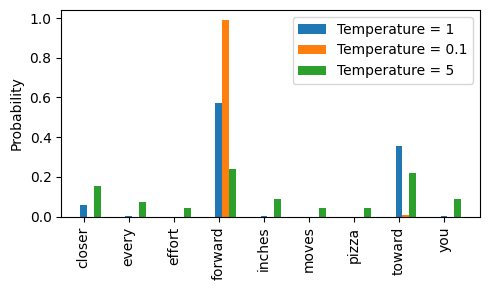

In [34]:
# 시각화
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 온도를 0.1로 조정하면 분포가 훨씬 뾰족해져 `torch.argmax`에 가까워지므로 가장 가능성이 높은 단어가 거의 항상 선택됩니다.

In [35]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 온도를 5로 조정하면 확률 분포가 더 균등하게 퍼집니다.

In [36]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 입력이 "every effort moves you"일 때 위 방법을 사용하면 3.2%(1000번 중 32번) 확률로 "every effort moves you pizza"처럼 어색한 문장이 나올 수 있습니다.

### 5.3.2 상위 k개(top-k) 샘플링

- 더 높은 온도로 다양성을 늘리면서도 말도 안 되는 문장 확률을 줄이려면, 샘플링 대상을 상위 k개의 가능성이 높은 토큰으로 제한할 수 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- (Please note that the numbers in this figure are truncated to two
digits after the decimal point to reduce visual clutter. The values in the Softmax row should add up to 1.0.)

- 이를 코드로 구현하면 다음과 같습니다.

In [37]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [38]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> NOTE:  
>
>  앞선 코드 셀을 조금 더 효율적으로 구현한 대안은 다음과 같습니다.
>
> ```python
> new_logits = torch.full_like( # -inf 값으로 채운 텐서 생성
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # 상위 k개의 값을 -inf 텐서에 복사
> ```
> <br>
> 자세한 내용은 https://github.com/rasbt/LLMs-from-scratch/discussions/326 을 참고하세요.

In [39]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 텍스트 생성 함수 수정하기

- 앞서 소개한 온도 조절과 top-k 샘플링을 이용해, 이전에 텍스트 생성을 위해 사용했던 `generate_simple` 함수를 확장해 새로운 `generate` 함수를 만들어 보겠습니다.

In [40]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # 반복문은 이전과 동일: 로짓을 계산하고 마지막 시점만 사용
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 추가: top_k 샘플링으로 로짓 필터링
        if top_k is not None:
            # 상위 k개의 값만 유지
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 추가: 온도 조절 적용
        if temperature > 0.0:
            logits = logits / temperature

            # 소프트맥스를 적용해 확률 계산
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 분포에서 샘플링
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 그 외에는 동일: 로짓이 가장 큰 어휘 인덱스를 선택
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # eos_id가 지정되었고 EOS 토큰이 나오면 조기 종료
            break

        # 이전과 동일: 샘플링한 인덱스를 시퀀스에 이어붙임
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [41]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


## 5.4 PyTorch에서 모델 가중치 저장과 불러오기

- LLM 학습에는 많은 비용이 들기 때문에, 가중치를 저장하고 다시 불러올 수 있는 기능이 매우 중요합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width="400px">

- PyTorch에서는 `.state_dict()` 메서드에 `torch.save`를 적용해 이른바 `state_dict`를 저장하는 방식이 권장됩니다.

In [42]:
torch.save(model.state_dict(), "model.pth")

- 그런 다음 새로운 `GPTModel` 인스턴스에 가중치를 불러올 수 있습니다.

In [43]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

- 일반 SGD 대신 Adam이나 AdamW 같은 적응형 옵티마이저로 LLM을 학습하는 경우가 흔합니다.
- 이러한 옵티마이저는 각 가중치마다 추가 매개변수를 저장하므로, 나중에 사전 학습을 이어갈 계획이라면 함께 저장하는 것이 좋습니다.

In [44]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [45]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 OpenAI 사전 학습 가중치 불러오기

- 앞에서는 교육 목적을 위해 아주 짧은 단편 소설 하나로 작은 GPT-2 모델만 학습했습니다.
- 전체 프로젝트 구텐베르크 코퍼스로 더 오래 사전 학습한 예시는 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)에서 확인할 수 있습니다.
- 다행히 거대한 코퍼스로 사전 학습하는 데 수만~수십만 달러를 쓰지 않아도, OpenAI가 제공하는 사전 학습 가중치를 불러오면 됩니다.

---

---


⚠️ **참고: TensorFlow 호환성 문제로 인해, 특히 일부 Windows 시스템에서는 이 절에서 문제가 발생할 수 있습니다. 여기서는 원본 OpenAI GPT-2 가중치 파일을 불러온 뒤 PyTorch로 변환하기 위해서만 TensorFlow가 필요합니다.
TensorFlow 관련 문제가 생기면, 이 절의 나머지 코드 대신 아래 대체 코드를 사용할 수 있습니다.
이 대체 코드는 앞 절에서 설명한 동일한 변환 과정을 거쳐 미리 변환해 둔 PyTorch 가중치를 기반으로 합니다. 자세한 내용은 노트북 [../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb)을 참고하세요.**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"  # 다른 모델 크기
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:
", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 먼저 OpenAI에서 파일을 내려받고 가중치를 Python으로 불러오기 위한 보일러플레이트 코드를 작성합니다.
- OpenAI는 [TensorFlow](https://www.tensorflow.org/)를 사용했으므로 가중치를 로드하려면 TensorFlow를 설치해 사용해야 합니다. [tqdm](https://github.com/tqdm/tqdm)은 진행률 표시줄 라이브러리입니다.
- 필요한 라이브러리를 설치하려면 다음 셀의 주석을 해제하고 실행하세요.

In [46]:
# pip install tensorflow tqdm

In [47]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [48]:
# 이 폴더에 있는 gpt_download.py에서 상대 경로로 가져오기

from gpt_download import download_and_load_gpt2
# 다른 방법:
# from llms_from_scratch.ch05 import download_and_load_gpt2

---

**참고**

- 매우 드물게 위 코드 셀 실행 시 `zsh: illegal hardware instruction python` 오류가 발생할 수 있는데, 이는 TensorFlow 설치 문제일 수 있습니다.
- 한 독자는 [이 게시글](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888)에서 언급했듯 `conda`로 TensorFlow를 설치해 문제를 해결했습니다.
- 추가 지침은 보충 자료인 [Python 설정 튜토리얼](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda)에서 확인할 수 있습니다.

---

- 그런 다음 1억 2400만 파라미터 모델의 가중치를 다음과 같이 내려받을 수 있습니다.

In [49]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|████████████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 63.1kiB/s]
encoder.json: 100%|████████████████████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 4.69MiB/s]
hparams.json: 100%|██████████████████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 59.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|████████████████████████████████████████████████████████████| 498M/498M [01:09<00:00, 7.15MiB/s]
model.ckpt.index: 100%|████████████████████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 2.32MiB/s]
model.ckpt.meta: 100%|███████████████████████████████████████████████████████████████████████████| 471k/471k [00:00<00:00, 2.19MiB/s]
vocab.bpe: 100%|█████████████████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 3.47MiB/s]


In [50]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [51]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [52]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 또한 `model_size` 인자로 "355M", "774M", "1558M"도 지원합니다.
- 서로 다른 모델 크기의 차이는 아래 그림에 요약되어 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- 위에서는 124M GPT-2 가중치를 Python으로 불러왔지만, 이제 이를 `GPTModel` 인스턴스에 옮겨야 합니다.
- 먼저 새로운 `GPTModel` 인스턴스를 초기화합니다.
- 원래 GPT 모델은 멀티헤드 어텐션 모듈의 쿼리·키·값 선형층에 편향 벡터를 사용했는데, 이는 반드시 필요하거나 권장되지는 않습니다. 그러나 가중치를 정확히 불러오려면 우리 구현에서도 `qkv_bias`를 `True`로 설정해 활성화해야 합니다.
- 또한 원본 GPT-2 모델에서 사용한 1024 토큰 컨텍스트 길이를 사용합니다.

In [53]:
# 간결하게 표현하기 위해 모델 설정을 딕셔너리로 정의
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 기본 설정을 복사한 뒤 모델별 설정으로 갱신
model_name = "gpt2-small (124M)"  # 예시 모델 이름
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 다음으로 OpenAI 가중치를 `GPTModel` 인스턴스의 해당 가중치 텐서에 할당해야 합니다.

In [54]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 가중치를 제대로 불러왔다면 이전의 `generate` 함수를 사용해 새로운 텍스트를 생성할 수 있습니다.

In [56]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- 모델이 일관성 있는 텍스트를 생성한다면 가중치가 올바르게 로드된 것입니다. 아주 작은 실수라도 있었다면 이런 결과를 얻지 못합니다.

- Hugging Face Hub에서 가중치를 불러오는 다른 방법은 [../02_alternative_weight_loading](../02_alternative_weight_loading)을 참고하세요.
- GPT 아키텍처가 Meta AI의 인기 LLM인 Llama 아키텍처와 어떻게 다른지 보고 싶다면 [../07_gpt_to_llama](../07_gpt_to_llama) 보너스 콘텐츠를 확인하세요.

## 요약 및 핵심 내용

- 학습을 위한 독립 실행형 스크립트는 [./gpt_train.py](./gpt_train.py)에서 확인하세요.
- [./gpt_generate.py](./gpt_generate.py)는 OpenAI 사전 학습 가중치를 불러와 프롬프트 기반 텍스트를 생성합니다.
- 연습 문제 풀이 노트북은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에서 찾아볼 수 있습니다.